# 实验二

## 任务一

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from cvxopt import matrix
from cvxopt import solvers
from sklearn.metrics import roc_auc_score

五个核函数

In [2]:
# 线性核函数
def liner(x, z):
    return np.inner(x, z)


#  多项式
def poly(x, z, c, p):
    return (np.inner(x, z) + c) ** p


# 高斯
def Gaussian(x, z, l):
    distance = np.sum((x - z) ** 2)
    return np.exp(-distance / (l * l))


def periodic(x, z, p, l):
    return np.exp((np.sin(np.pi * np.linalg.norm(x - z) / p) ** 2) /((l ** 2) * -2))


def RBF(x, z, a, r):
    return a * np.exp(-r * np.linalg.norm(x - z))

In [3]:
kernel_functions = [liner,poly, Gaussian, periodic, RBF]
kernel_names = [ 'liner','polynomial', 'Gaussian', 'Periodic', 'RBF']
kernel_parameters = [
    [],
    [3, 2],
    [2],
    [1, 2],
    [1, 1]
    ]

In [4]:
t_x = np.linspace(-5, 5, 1000)

    多项式几何函数，p/c越大函数斜率越大
     l越大，高斯分布的方差越大，即图像开口越大
    周期核函数，p越大抖动的频率越小，l越带值越小
    a控制函数图像高低，a越大函数值越大，r控制开口大小，r越大开口越小


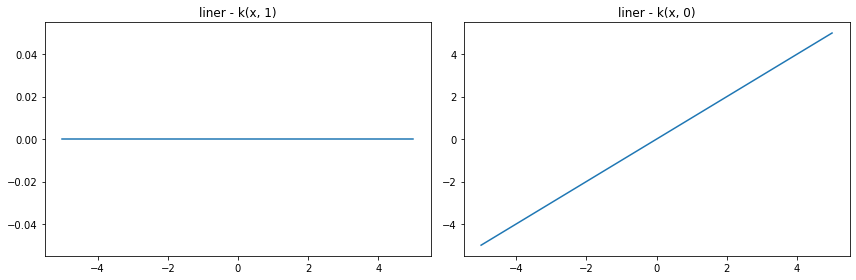

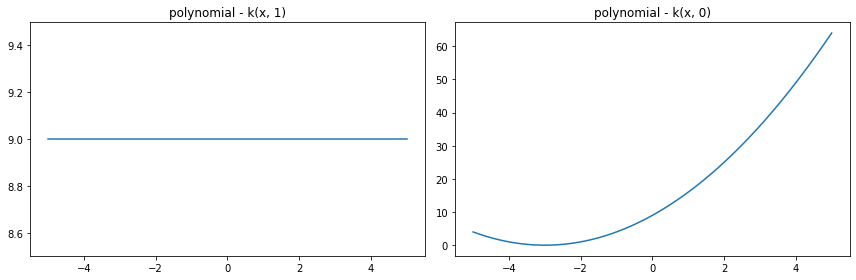

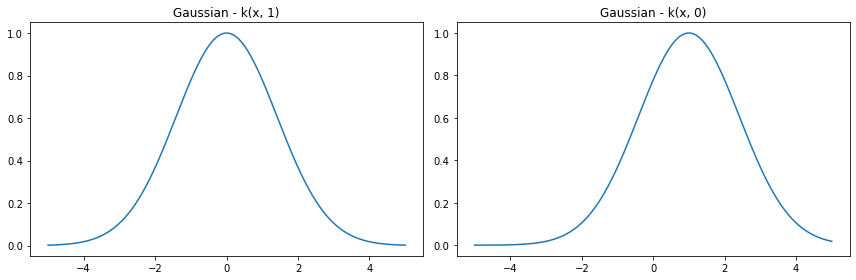

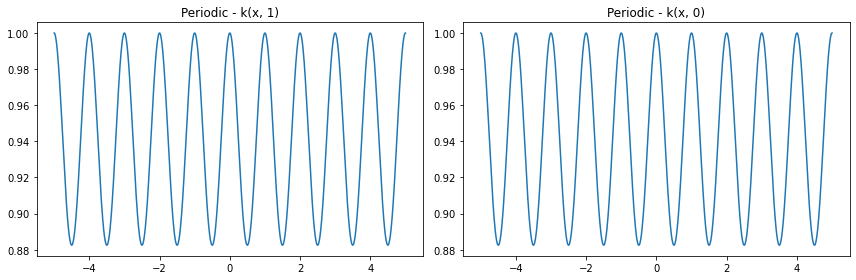

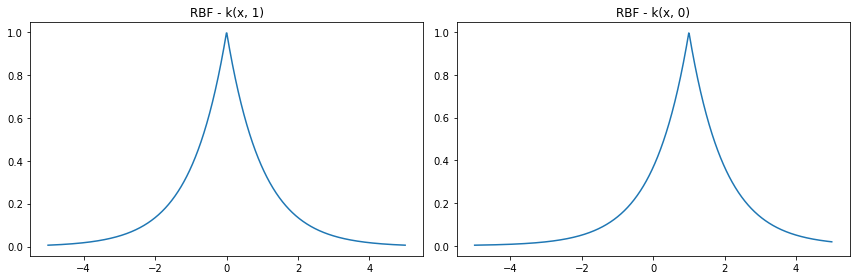

In [5]:
for kernel_name, kernel, kernel_params in zip(kernel_names, kernel_functions, kernel_parameters):
        k1 = [kernel(x, 0, *kernel_params)for x in t_x]
        k2 = [kernel(x, 1, *kernel_params)for x in t_x]

        plt.figure(figsize=(12, 4))
        plt.subplot(121)
        plt.plot(t_x, k1)
        plt.title(f'{kernel_name} - k(x, 1)')

        plt.subplot(122)
        plt.plot(t_x, k2)
        plt.title(f'{kernel_name} - k(x, 0)')

        plt.tight_layout()
        plt.show()

## 任务二 ：生成读入数据集

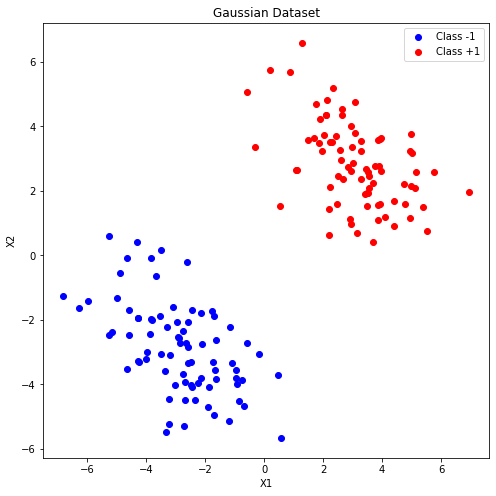

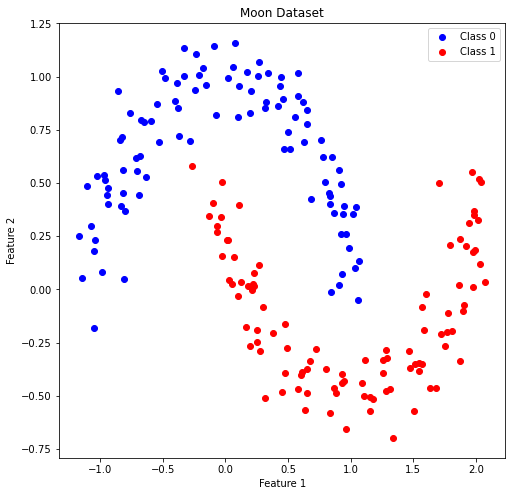

In [6]:

    # 生成Gaussian数据集
    # 随机种子确保每次随机生成的数据一直
np.random.seed(0)
    # 生成X1和X2的样本点
mean1 = np.array([-3, -3])
mean2 = np.array([3, 3])
cov = np.array([[2, -1], [-1, 2]])
X1 = np.random.multivariate_normal(mean1, cov, 80)
X2 = np.random.multivariate_normal(mean2, cov, 80)

    # 创建标签，-1表示X1样本点，+1表示X2样本点
y1 = -np.ones(80)
y2 = np.ones(80)
# 合并数据集
X = np.vstack((X1, X2))
Y = np.hstack((y1, y2))

# 划分数据集为训练集、验证集和测试集
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=0)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=0)

    # 绘制Gaussian数据集
plt.figure(figsize=(8, 8))
plt.scatter(X1[:, 0], X1[:, 1], c='blue', label='Class -1')
plt.scatter(X2[:, 0], X2[:, 1], c='red', label='Class +1')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(loc='best')
plt.title('Gaussian Dataset')
plt.show()

    # 读入Moon数据集
X_moon, Y_moon = make_moons(n_samples=200, noise=0.1, random_state=0)

Y_moon[Y_moon == 0] = -1
Y_moon= Y_moon.astype(float)
    # 划分Moon数据集为训练集、验证集和测试集
X_train_moon, X_temp_moon, Y_train_moon, Y_temp_moon = train_test_split(X_moon, Y_moon, test_size=0.4,                                                            random_state=0)
X_val_moon, X_test_moon, Y_val_moon, Y_test_moon = train_test_split(X_temp_moon, Y_temp_moon, test_size=0.5,
                                                                        random_state=0)

# 绘制Moon数据集
plt.figure(figsize=(8, 8))
plt.scatter(X_moon[Y_moon == -1, 0], X_moon[Y_moon == -1, 1], c='blue', label='Class 0')
plt.scatter(X_moon[Y_moon == 1, 0], X_moon[Y_moon == 1, 1], c='red', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.title('Moon Dataset')
plt.show()




## 任务三

In [7]:
def train_svm(X, Y, kernel, kernel_params):
    K = kernel(X, X, *kernel_params)
    p = matrix(np.outer(Y, Y) * K)
    q = matrix(-np.ones(len(Y)))
    G = matrix(np.diag(-np.ones(len(Y))))
    h = matrix(np.zeros(len(Y)))
    A = matrix(Y, (1, len(Y)))
    b = matrix(0.0)

    sol = solvers.qp(p, q, G, h, A, b)
    alphas = np.array(sol['x'])
    support_vector = (alphas > 1e-4).flatten()

    v_alphas = alphas[support_vector]
    v = X[support_vector]
    v_lable = Y[support_vector]
    return v_alphas, v, v_lable


In [20]:
# 决策函数和决策边界画图
def get_result(X, alphas, v, v_l, kernel, kernel_parameters):
    result = np.sum(alphas * v_l * np.array([kernel(X, sv, *kernel_parameters) for sv in v]))
    return result

# def plot(X, y, alphas, v, v_l, kernel, kernel_parameters, name):
#
#     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
#     grid_points = np.c_[xx.ravel(), yy.ravel()]
#
#     Z = np.array(
#         [get_result(point, alphas, v, v_l
#         , kernel, kernel_parameters) for point in grid_points])
#     Z = Z.reshape(xx.shape)
#
#     plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
#     plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
#     plt.xlabel('Feature 1')
#     plt.ylabel('Feature 2')
#     plt.title(name)
#     plt.show()
#
def plot(X, y, alphas, v, v_l, kernel, kernel_parameters, name):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = np.array([get_result(point, alphas, v, v_l, kernel, kernel_parameters) for point in grid_points])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')

    # 绘制数据点
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', marker='o', s=100)

    # 绘制支持向量
    # sv_idx = alphas > 1e-5  # 选择非零的 alpha
    # plt.scatter(X[sv_idx, 0], X[sv_idx, 1], c='r', marker='o', s=200, label='Support Vectors', edgecolors='k')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(name)
    plt.legend()
    plt.show()


Kernel: liner
     pcost       dcost       gap    pres   dres
 0: -4.4937e+00 -7.0603e+00  2e+02  1e+01  2e+00
 1: -2.6030e+00 -5.3223e-01  2e+01  1e+00  1e-01
 2: -3.8275e-02 -1.9748e-01  2e-01  4e-03  4e-04
 3: -8.5067e-02 -1.1603e-01  4e-02  5e-04  6e-05
 4: -1.0982e-01 -1.1500e-01  5e-03  3e-05  4e-06
 5: -1.1397e-01 -1.1403e-01  6e-05  4e-07  4e-08
 6: -1.1402e-01 -1.1402e-01  6e-07  4e-09  4e-10
 7: -1.1402e-01 -1.1402e-01  6e-09  4e-11  4e-12
Optimal solution found.


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

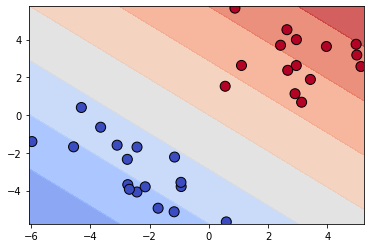

In [16]:

for kernel_name, kernel, kernel_params in zip(kernel_names, kernel_functions, kernel_parameters):
    print(f"Kernel: {kernel_name}")
    v_alphas, v, v_label = train_svm(X_train, Y_train, kernel, kernel_params)
    plot(X_test, Y_test, v_alphas, v, v_label, kernel,kernel_params, kernel_name)

Kernel: liner
     pcost       dcost       gap    pres   dres
 0: -4.4172e+01 -1.1896e+02  5e+02  2e+01  3e+00
 1: -1.6210e+02 -3.0668e+02  4e+02  1e+01  2e+00
 2: -7.5020e+02 -1.0449e+03  3e+02  8e+00  1e+00
 3: -2.0038e+03 -2.4266e+03  4e+02  7e+00  1e+00
 4: -7.3481e+03 -8.1911e+03  9e+02  7e+00  1e+00
 5: -5.7950e+04 -5.9879e+04  2e+03  6e+00  1e+00
 6: -6.2724e+05 -6.4150e+05  1e+04  6e+00  1e+00
 7: -2.2459e+06 -2.2941e+06  5e+04  6e+00  1e+00
 8: -3.8896e+06 -3.9717e+06  8e+04  6e+00  1e+00
 9: -1.8773e+08 -1.8782e+08  9e+04  6e+00  1e+00
10: -3.0658e+11 -3.0661e+11  3e+07  6e+00  1e+00
11: -9.5574e+11 -9.5585e+11  1e+08  6e+00  1e+00
12: -1.0800e+12 -1.0801e+12  1e+08  6e+00  1e+00
13: -1.4608e+12 -1.4610e+12  2e+08  6e+00  1e+00
Terminated (singular KKT matrix).


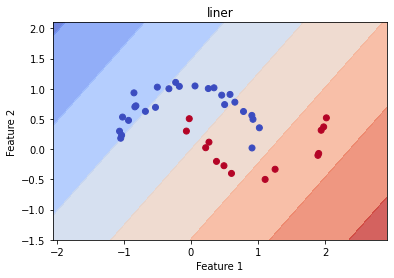

Kernel: polynomial
     pcost       dcost       gap    pres   dres
 0: -4.3089e+01 -1.1271e+02  5e+02  2e+01  3e+00
 1: -1.6558e+02 -3.0660e+02  4e+02  1e+01  2e+00
 2: -7.1246e+02 -1.0097e+03  3e+02  9e+00  1e+00
 3: -2.2778e+03 -2.6363e+03  4e+02  7e+00  1e+00
 4: -7.4276e+03 -8.2385e+03  8e+02  7e+00  1e+00
 5: -4.2960e+04 -4.5434e+04  2e+03  6e+00  1e+00
 6: -2.0739e+05 -2.1683e+05  9e+03  6e+00  1e+00
 7: -1.8198e+06 -1.8746e+06  5e+04  6e+00  1e+00
 8: -4.5790e+07 -4.6194e+07  4e+05  6e+00  1e+00
 9: -4.9971e+09 -4.9994e+09  2e+06  6e+00  1e+00
10: -5.7106e+09 -5.7133e+09  3e+06  6e+00  1e+00
11: -1.1525e+10 -1.1530e+10  5e+06  6e+00  1e+00
12: -2.9513e+10 -2.9527e+10  1e+07  6e+00  1e+00
13: -4.2071e+10 -4.2091e+10  2e+07  6e+00  1e+00
14: -6.2213e+10 -6.2243e+10  3e+07  6e+00  1e+00
15: -1.0218e+11 -1.0223e+11  5e+07  6e+00  1e+00
16: -1.9603e+11 -1.9611e+11  8e+07  6e+00  1e+00
17: -2.3514e+11 -2.3523e+11  9e+07  6e+00  1e+00
18: -3.7359e+11 -3.7369e+11  1e+08  6e+00  1e+00
Te

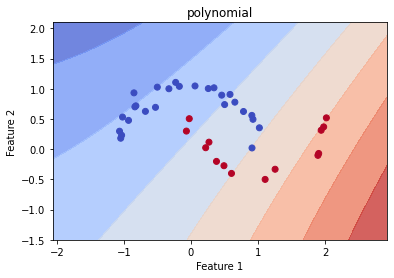

Kernel: Gaussian
     pcost       dcost       gap    pres   dres
 0: -1.1970e+02 -2.4539e+02  1e+02  2e-16  2e+00
 1: -2.9037e+02 -2.9342e+02  3e+00  8e-15  1e+00
 2: -2.7952e+04 -2.7955e+04  3e+00  2e-12  1e+00
 3: -2.6360e+08 -2.6360e+08  3e+02  1e-08  1e+00
 4: -2.7681e+11 -2.7681e+11  3e+05  5e-06  1e+00
Terminated (singular KKT matrix).


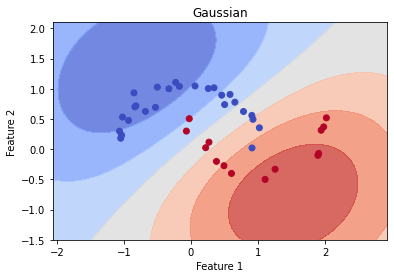

Kernel: Periodic
     pcost       dcost       gap    pres   dres
 0: -1.1970e+02 -2.4539e+02  1e+02  2e-16  2e+00
 1: -2.9037e+02 -2.9342e+02  3e+00  8e-15  1e+00
 2: -2.7952e+04 -2.7955e+04  3e+00  2e-12  1e+00
 3: -2.6360e+08 -2.6360e+08  3e+02  1e-08  1e+00
 4: -2.7681e+11 -2.7681e+11  3e+05  5e-06  1e+00
Terminated (singular KKT matrix).


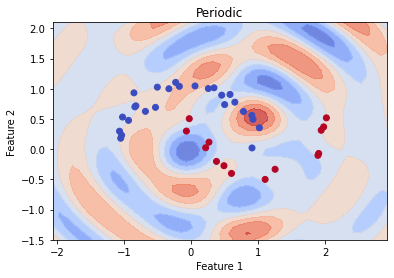

Kernel: RBF
     pcost       dcost       gap    pres   dres
 0: -1.1970e+02 -2.4539e+02  1e+02  2e-16  2e+00
 1: -2.9037e+02 -2.9342e+02  3e+00  8e-15  1e+00
 2: -2.7952e+04 -2.7955e+04  3e+00  2e-12  1e+00
 3: -2.6360e+08 -2.6360e+08  3e+02  1e-08  1e+00
 4: -2.7681e+11 -2.7681e+11  3e+05  5e-06  1e+00
Terminated (singular KKT matrix).


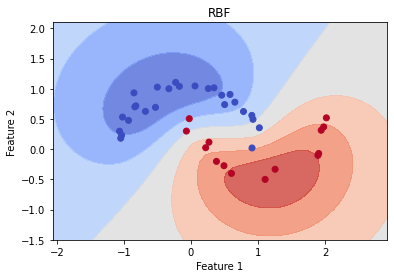

In [10]:
# moon数据集
for kernel_name, kernel, kernel_params in zip(kernel_names, kernel_functions, kernel_parameters):
    print(f"Kernel: {kernel_name}")
    v_alphas, v, v_label = train_svm(X_train_moon, Y_train_moon, kernel, kernel_params)
    plot(X_test_moon, Y_test_moon, v_alphas, v, v_label, kernel,kernel_params, kernel_name)


gried screach

In [11]:
# 创建参数网格

param_grids = {
    'liner': {'C': []},
    'polynomial': {'C': [0.1, 1., 10.], 'C1': [2., 3., 4.]},
    'Gaussian': {'C': [0.1, 1., 10.]},
    'Periodic': {'C': [0.1, 1., 10.],'C1': [2., 3., 4.]},
    'RBF': {'C': [0.1, 1, 10], 'C1': [0.1, 1, 10]}
}

best_auc_params = {}

def custom_auc_scorer(kernel_name, kernel, X, y):
    # 获取当前核函数对应的参数网格
    kernel_params = param_grids[kernel_name]
    t = [] # t我用来储存每次的参数
    best_auc = 0.0
    best_params = {}

    # 这是因为liner没有参数，所以我单写出来计算
    if kernel_name == 'liner':
        v_alphas, v, v_label = train_svm(X, y, kernel, [])
                # 预测概率得分
        y_pred = np.array([get_result(x, v_alphas, v, v_label, kernel, [ ]) for x in X])
                # 计算AUC
        auc = roc_auc_score(y, y_pred)
        best_auc_params[kernel_name] = (auc, 0)
    for C in kernel_params['C']:
        t = [C]
        if 'C1' in kernel_params:
            for C1 in kernel_params['C1']:
                # 训练SVM模型
                t = [C, C1]
                print(t)
                v_alphas, v, v_label = train_svm(X, y, kernel, t)
                # 预测概率得分
                y_pred = np.array([get_result(x, v_alphas, v, v_label, kernel,t) for x in X])
                # 计算AUC
                auc = roc_auc_score(y, y_pred)
                if auc > best_auc:
                    best_auc = auc
                    best_params = t
        else:
            v_alphas, v, v_label = train_svm(X, y, kernel, t)
                # 预测概率得分
            y_pred = np.array([get_result(x, v_alphas, v, v_label, kernel,t) for x in X])
                # 计算AUC
            auc = roc_auc_score(y, y_pred)
            if auc > best_auc:
                best_auc = auc
                best_params = t
    # 保存最佳AUC和参数到字典中
    if kernel_name != 'liner':
        best_auc_params[kernel_name] = (best_auc, best_params)

# 手动Grid Search
for kernel_name, kernel  in zip(kernel_names, kernel_functions):
    custom_auc_scorer(kernel_name, kernel, X_val, Y_val)

# 打印每个核函数的最佳AUC和参数
for kernel_name, (best_auc, best_params) in best_auc_params.items():
    print(f"Kernel: {kernel_name}, Best AUC: {best_auc}, Best Parameters: {best_params}")

     pcost       dcost       gap    pres   dres
 0: -1.6415e+00 -2.4144e+00  7e+01  8e+00  1e+00
 1: -5.2142e-01 -2.4947e-01  5e+00  6e-01  1e-01
 2: -9.1791e-03 -1.8015e-01  2e-01  2e-16  2e-15
 3: -5.9063e-02 -8.2101e-02  2e-02  1e-17  6e-16
 4: -7.4321e-02 -8.2633e-02  8e-03  1e-17  3e-16
 5: -7.9870e-02 -8.0418e-02  5e-04  3e-17  3e-16
 6: -8.0261e-02 -8.0268e-02  7e-06  3e-17  4e-16
 7: -8.0266e-02 -8.0266e-02  7e-08  3e-17  3e-16
Optimal solution found.
[0.1, 2.0]
     pcost       dcost       gap    pres   dres
 0: -1.5740e+00 -2.5955e+00  6e+01  8e+00  1e+00
 1: -3.4252e-01 -1.0045e+00  4e+00  4e-01  8e-02
 2: -1.7530e-01 -6.4318e-01  5e-01  1e-16  1e-14
 3: -3.1562e-01 -3.8997e-01  7e-02  8e-17  6e-15
 4: -3.6652e-01 -3.7537e-01  9e-03  4e-17  8e-15
 5: -3.6980e-01 -3.7266e-01  3e-03  7e-17  6e-15
 6: -3.7146e-01 -3.7239e-01  9e-04  6e-17  8e-15
 7: -3.7207e-01 -3.7211e-01  4e-05  1e-16  1e-14
 8: -3.7211e-01 -3.7211e-01  6e-07  8e-17  9e-15
 9: -3.7211e-01 -3.7211e-01  6e-09  

[1.0, 1.0, 1.0, 0.8015873015873016, 1.0]


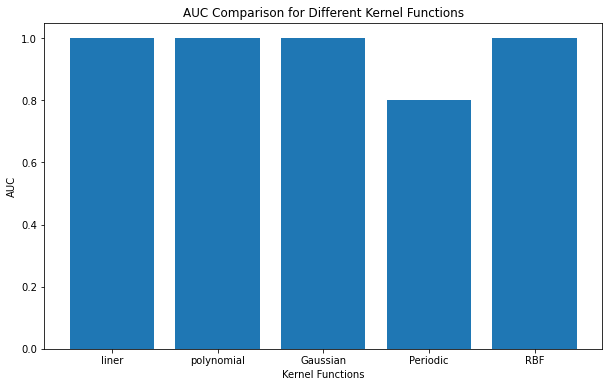

In [12]:
# 绘制 AUC 图
# 提取每个核函数的最优 AUC 值和参数
best_aucs = [best_auc_params[kernel][0] for kernel in kernel_names]
print(best_aucs)
plt.figure(figsize=(10, 6))
bars = plt.bar(kernel_names, best_aucs)
plt.xlabel('Kernel Functions')
plt.ylabel('AUC')
plt.title('AUC Comparison for Different Kernel Functions')
# 在每个柱形上添加 AUC 值标签
plt.show()

In [13]:

# 手动Grid Search
for kernel_name, kernel  in zip(kernel_names, kernel_functions):
    custom_auc_scorer(kernel_name, kernel, X_val_moon, Y_val_moon)

# 打印每个核函数的最佳AUC和参数
for kernel_name, (best_auc, best_params) in best_auc_params.items():
    print(f"Kernel: {kernel_name}, Best AUC: {best_auc}, Best Parameters: {best_params}")

     pcost       dcost       gap    pres   dres
 0: -1.4669e+01 -3.7217e+01  1e+02  8e+00  2e+00
 1: -6.4256e+01 -9.7847e+01  7e+01  5e+00  1e+00
 2: -3.0835e+02 -3.9350e+02  9e+01  4e+00  1e+00
 3: -1.0677e+03 -1.2121e+03  1e+02  4e+00  1e+00
 4: -7.6994e+03 -7.9736e+03  3e+02  3e+00  1e+00
 5: -4.4060e+04 -4.5375e+04  1e+03  3e+00  1e+00
 6: -5.7545e+05 -5.8661e+05  1e+04  3e+00  1e+00
 7: -2.4702e+07 -2.4799e+07  1e+05  3e+00  1e+00
 8: -6.1243e+09 -6.1252e+09  9e+05  3e+00  1e+00
 9: -2.2157e+12 -2.2160e+12  3e+08  3e+00  1e+00
Terminated (singular KKT matrix).
[0.1, 2.0]
     pcost       dcost       gap    pres   dres
 0: -1.6321e+01 -4.1181e+01  1e+02  8e+00  2e+00
 1: -6.5496e+01 -9.7038e+01  7e+01  5e+00  1e+00
 2: -3.0408e+02 -3.8554e+02  9e+01  4e+00  1e+00
 3: -1.0571e+03 -1.2039e+03  1e+02  4e+00  1e+00
 4: -4.0631e+03 -4.4329e+03  4e+02  4e+00  1e+00
 5: -3.1732e+04 -3.2976e+04  1e+03  4e+00  1e+00
 6: -5.2485e+05 -5.3335e+05  9e+03  4e+00  1e+00
 7: -2.5415e+07 -2.5516e+0

[0.9002557544757033, 0.8976982097186701, 1.0, 0.9130434782608696, 1.0]


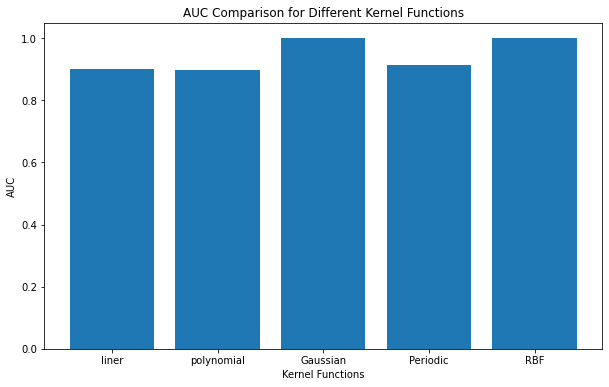

In [14]:

# 绘制 AUC 图
# 提取每个核函数的最优 AUC 值和参数
best_aucs = [best_auc_params[kernel][0] for kernel in kernel_names]
print(best_aucs)
plt.figure(figsize=(10, 6))
bars = plt.bar(kernel_names, best_aucs)
plt.xlabel('Kernel Functions')
plt.ylabel('AUC')
plt.title('AUC Comparison for Different Kernel Functions')
# 在每个柱形上添加 AUC 值标签
plt.show()

###  在实验中确实遇到了很多很多的问题，这个实验昨晚着实不容易，以下是实验中遇见的问题及反思
1、在做矩阵运算时，有些函数不能用在二维，（一维不会出错、但是二维的会）
2、二维矩阵的二范数得用np.linalg.norm() ，使用 ** 的话也有维度问题
3、在计算svm优化的时候，注意每个参数的值和纬度
4、grid scearch 我在掉包的时候属实做不出来，所以自己写的实现过程
